In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython.display import Video
from matplotlib import animation

The conservative shallow water equations are given below:

$$ \frac{\partial U}{\partial t} +\frac{\partial (U^2/h)}{\partial x} - fV = -\frac{1}{2} g \frac{\partial (h^2)}{\partial x} $$

$$ \frac{\partial V}{\partial t} + \frac{\partial (UV/h)}{\partial x} + fU = 0 $$

$$ \frac{\partial h}{\partial t} + \frac{\partial U}{\partial x} = 0 $$

where $h$ is the wave height, $U = u h$ and $V = v h$ are the depth integrated velocities, and $f$ is the coriolis frequency.

## Unstaggered Grid

In [2]:
import Euler.Periodic_1D as elr

In [3]:
g = 9.81

day = 24*60*60 # length of day [seconds]
omega = 2*np.pi / day
#f = 0
f = 2*omega*np.sin(np.deg2rad(30))

In [22]:
Lx = 6
nx = 400
dx = Lx/nx

x = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)

In [9]:
def spatial_diff(adv_speed, fun, dx, nx):
    f3 = np.zeros(nx-1)
    for j in np.arange(1, fun.size - 1, 1):
        if(adv_speed[j] >=0):
            f3[j-1] = 1/(dx) * (fun[j]-fun[j-1])
        else:
            f3[j-1] = 1/(dx) * (fun[j+1]-fun[j])
    return f3

def periodic_BC(U_new, V_new, h_new):
    U_new[-1] = U_new[1]
    U_new[0] = U_new[-2]
    V_new[-1] = V_new[1]
    V_new[0] = V_new[-2]
    h_new[-1] = h_new[1]
    h_new[0] = h_new[-2]

In [24]:
U_old = np.zeros(nx+1)
V_old = np.zeros(nx+1)
U_new = np.zeros(nx+1)
V_new = np.zeros(nx+1)

h_old = 1 + 0.01*np.exp(-5*x**2)
h_new = np.zeros(nx+1)

t_start = 0
t_end = 1.5
dt = 0.0005

for t in np.arange(t_start, t_end, dt):
    
    # Governing equations for interior points
    #U_new = U_old - dt*elr.partial_x_cd(U_old*U_old/h_old, dx, nx+1) + f*dt*V_old - 0.5*dt*g*elr.partial_x_cd(h_old**2, dx, nx+1)
    U_new[1:nx] = U_old[1:nx] - dt*spatial_diff(U_old, U_old*U_old/h_old, dx, nx) + f*dt*V_old[1:nx] - 0.5*dt*g*elr.partial_x_cd(h_old**2, dx, nx+1)[1:nx]
    
    V_new[1:nx] = V_old[1:nx] - dt*spatial_diff(U_old, U_old*V_old/h_old, dx, nx) - f*dt*U_old[1:nx]
    
    h_new[1:nx] = h_old[1:nx] - dt*elr.partial_x_cd(U_old, dx, nx)[1:nx]
    
    # Boundary conditions
    periodic_BC(U_new, V_new, h_new)
    #U_new[0], U_new[-1] = 0, 0
    #V_new[0], V_new[-1] = 0, 0
    #h_new[0], h_new[-1] = 1, 1
    
    # Updation equations
    U_old = U_new
    V_old = V_new
    h_old = h_new

Text(0.5, 1.0, '1D conservative SWE on an unstaggered grid')

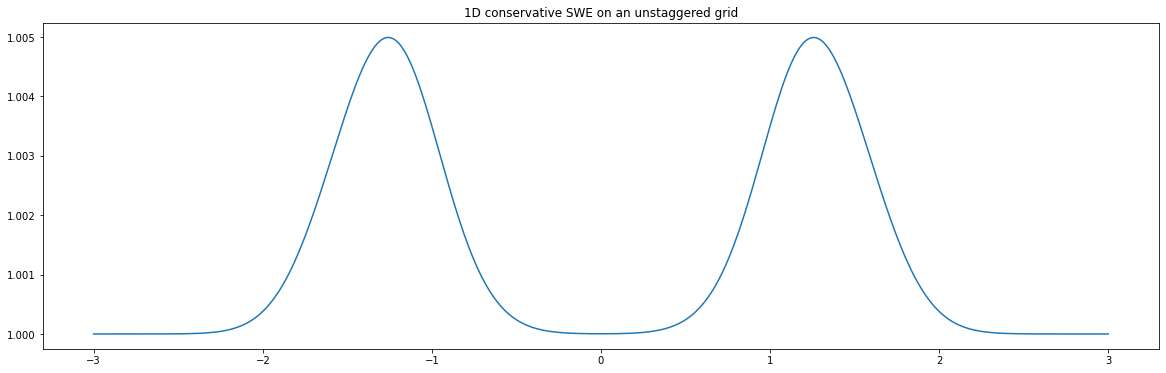

In [25]:
plt.figure(figsize = (20,6))
plt.plot(x, h_new)
plt.title('1D conservative SWE on an unstaggered grid')

### Important conclusion

1. Like the 1D SWE non-conservative case, the code works fine till the time the two waves don't interact with the boundaries. As soon as the waves start interacting with the boundaries, instabilities occur.

## Leap frog on unstaggered grid

In [46]:
Lx = 6
nx = 400
dx = Lx/nx

x = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)

In [47]:
def periodic_BC(U_new, V_new, h_new):
    U_new[-1] = U_new[1]
    U_new[0] = U_new[-2]
    V_new[-1] = V_new[1]
    V_new[0] = V_new[-2]
    h_new[-1] = h_new[1]
    h_new[0] = h_new[-2]
    
def Dirichlet_BC(U_new, V_new, h_new):
    U_new[0], U_new[-1] = 0, 0
    V_new[0], V_new[-1] = 0, 0
    h_new[0] = 1
    h_new[-1] = 1

In [48]:
U_older = np.zeros(nx+1)
V_older = np.zeros(nx+1)
U_old = np.zeros(nx+1)
V_old = np.zeros(nx+1)
U_new = np.zeros(nx+1)
V_new = np.zeros(nx+1)

h_older = np.zeros(nx+1)
h_old = 1 + 0.01*np.exp(-5*x**2)
h_new = np.zeros(nx+1)

t_start = 0
t_end = 1.5
dt = 0.0005

count = 0

for t in np.arange(t_start, t_end, dt):
    
    if(count == 0):
        #U_new[1:nx] = U_old[1:nx] - dt*elr.partial_x_cd(U_old*U_old/h_old, dx, nx+1)[1:nx] + f*dt*V_old[1:nx] - 0.5*dt*g*elr.partial_x_cd(
        #    h_old**2, dx, nx+1)[1:nx]
        #V_new[1:nx] = V_old[1:nx] - dt*elr.partial_x_cd(U_old*V_old/h_old, dx, nx+1)[1:nx] - f*dt*U_old[1:nx]
        #h_new[1:nx] = h_old[1:nx] - dt*elr.partial_x_cd(U_old, dx, nx+1)[1:nx]
        U_new[1:nx] = U_old[1:nx] - dt*spatial_diff(U_old, U_old*U_old/h_old, dx, nx) + f*dt*V_old[1:nx] - 0.5*dt*g*elr.partial_x_cd(
            h_old**2, dx, nx+1)[1:nx]
        V_new[1:nx] = V_old[1:nx] - dt*spatial_diff(U_old, U_old*V_old/h_old, dx, nx) - f*dt*U_old[1:nx]
        h_new[1:nx] = h_old[1:nx] - dt*elr.partial_x_cd(U_old, dx, nx+1)[1:nx]
    else:
        #U_new[1:nx] = U_older[1:nx] - 2*(dt*elr.partial_x_cd(U_old*U_old/h_old, dx, nx+1)[1:nx] + f*dt*V_old[1:nx] - 0.5*dt*g*elr.partial_x_cd(
        #    h_old**2, dx, nx+1)[1:nx])
        #V_new[1:nx] = V_older[1:nx] - 2*(dt*elr.partial_x_cd(U_old*V_old/h_old, dx, nx+1)[1:nx] - f*dt*U_old[1:nx])
        #h_new[1:nx] = h_older[1:nx] - 2*(dt*elr.partial_x_cd(U_old, dx, nx+1))[1:nx]
        U_new[1:nx] = U_older[1:nx] - 2*(dt*spatial_diff(U_old, U_old*U_old/h_old, dx, nx) - f*dt*V_old[1:nx] + 0.5*dt*g*elr.partial_x_cd(
            h_old**2, dx, nx+1)[1:nx])
        V_new[1:nx] = V_older[1:nx] - 2*(dt*spatial_diff(U_old, U_old*V_old/h_old, dx, nx) + f*dt*U_old[1:nx])
        h_new[1:nx] = h_older[1:nx] - 2*(dt*elr.partial_x_cd(U_old, dx, nx+1)[1:nx])
        
    # Boundary conditions
    periodic_BC(U_new, V_new, h_new)
    
    # Updation equations
    U_older = U_old
    V_older = V_old
    h_older = h_old
    U_old = U_new
    V_old = V_new
    h_old = h_new
    
    count = count + 1

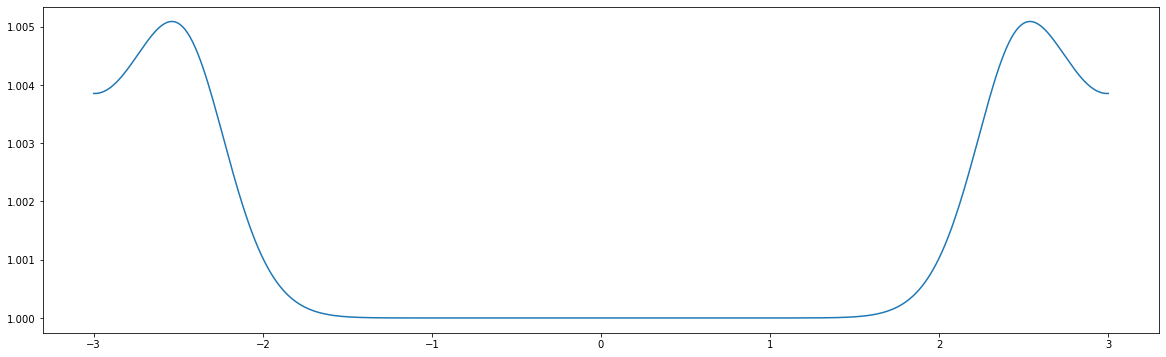

In [49]:
plt.figure(figsize = (20,6))
plt.plot(x, h_old)

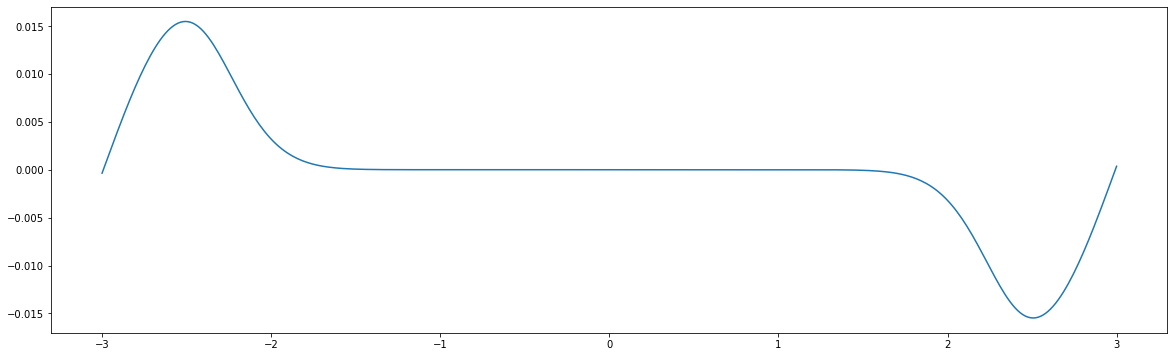

In [50]:
plt.figure(figsize = (20,6))
plt.plot(x, U_old)

## Staggered grid

In [31]:
Lx = 6
nx = 400
dx = Lx/nx

xu = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)
xt = xu + dx/2
xt = xt[0:-1]

In [7]:
def u_to_t(phi_U, nx, dx):
    
    phi_T = np.zeros(nx)
    
    phi_T = (phi_U[0:nx-1] + phi_U[1:nx])/2
    return phi_T

def t_to_u(phi_T, nx, dx):
    
    phi_U = np.zeros(nx+1)
    
    phi_U[1:nx] = (phi_T[0:nx-1] + phi_T[1:nx])/2
    phi_U[0] = (3 * phi_T[0] - phi_T[1])*0.5
    phi_U[-1] = (3 * phi_T[-1] - phi_T[-2])*0.5
    return phi_U

In [33]:
U_old = np.zeros(nx+1)
U_new = np.zeros(nx+1)
V_old = np.zeros(nx+1)
V_new = np.zeros(nx+1)

h_old = 1 + 0.01*np.exp(-4*(xt)**2)
h_new = np.zeros(nx)

t_start = 0
t_end = 1.5
dt = 0.0005

count = 0

for t in np.arange(t_start, t_end, dt):    
    # Governing equations for interior points
    U_avg = u_to_t(U_old, nx, dx)
    h_avg = t_to_u(h_old, nx, dx)
    
    U_new[1:nx] = U_old[1:nx] - dt*spatial_diff(U_old, U_old*U_old/h_avg, dx, nx) + f*dt*V_old[1:nx] - 0.5*dt*g*elr.partial_x_cd(h_avg**2, dx, nx+1)[1:nx]
    V_new[1:nx] = V_old[1:nx] - dt*spatial_diff(U_old, U_old*V_old/h_avg, dx, nx) - f*dt*U_old[1:nx]
    h_new[1:nx-1] = h_old[1:nx-1] - dt*elr.partial_x_cd(U_avg, dx, nx)[1:nx-1]
    
    # Boundary conditions
    # Dirichlet
    #U_new[0], U_new[-1] = 0, 0
    #V_new[0], V_new[-1] = 0, 0
    #h_new[0] = (1 + h_new[1]/2)*(2/3)
    #h_new[-1] = (1 + h_new[-2]/2)*(2/3)
    
    # Periodic
    U_new[-1] = U_new[1]
    U_new[0] = U_new[-2]
    V_new[-1] = V_new[1]
    V_new[0] = V_new[-2]
    h_new[-1] = h_new[1]
    h_new[0] = h_new[-2]
    
    # Updation equations
    U_old = U_new
    V_old = V_new
    h_old = h_new
    
    count = count + 1

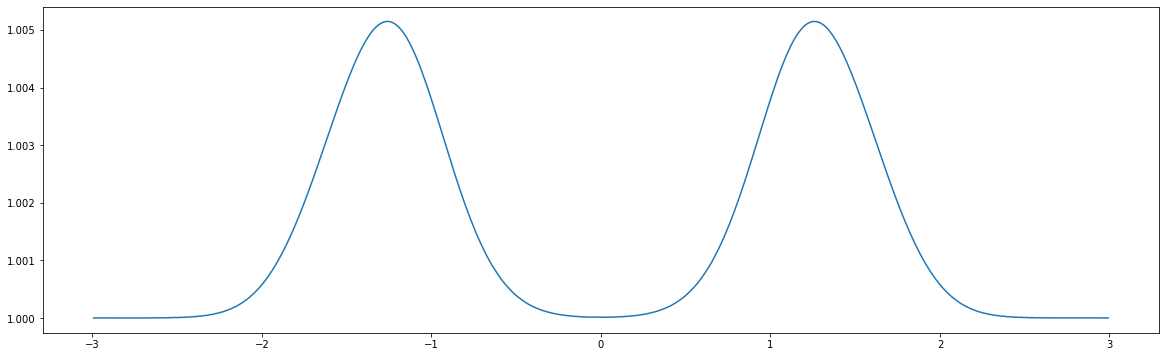

In [34]:
plt.figure(figsize = (20,6))
plt.plot(xt, h_old)

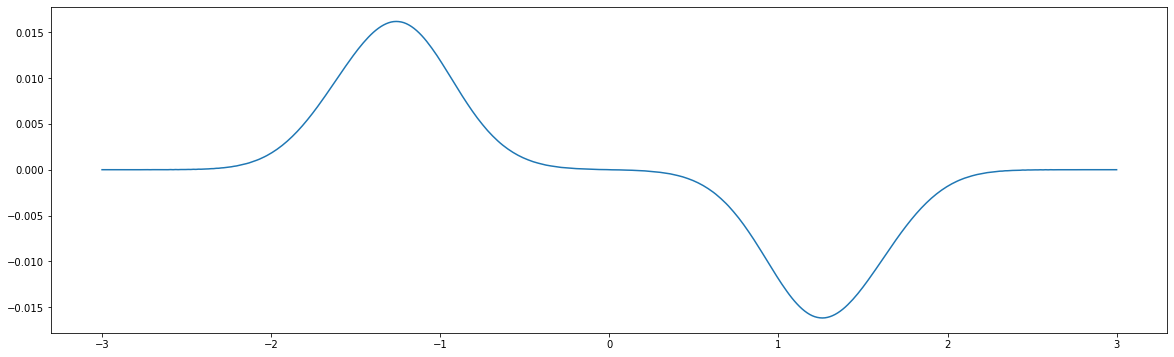

In [35]:
plt.figure(figsize = (20,6))
plt.plot(xu, U_old)

## Important takeaways

1. The conservative form of the shallow water equations do not work even for the staggered grid. It remains to be understood whether this is a normal outcome or the code has some unnoticed error.
2. The periodic boundary conditions run smoothly for the first couple of seconds, but after that, the instabilities increase rapidly.

## Using leap frog scheme

In [4]:
Lx = 6
nx = 200
dx = Lx/nx

xu = np.linspace(-Lx/2,Lx/2,nx+1,dtype = float)
xt = xu + dx/2
xt = xt[0:-1]

In [5]:
def periodic_BC(U_new, V_new, h_new):
    U_new[-1] = U_new[1]
    U_new[0] = U_new[-2]
    V_new[-1] = V_new[1]
    V_new[0] = V_new[-2]
    h_new[-1] = h_new[1]
    h_new[0] = h_new[-2]
    
def Dirichlet_BC(U_new, V_new, h_new):
    U_new[0], U_new[-1] = 0, 0
    V_new[0], V_new[-1] = 0, 0
    h_new[0] = (1 + h_new[1]/2)*(2/3)
    h_new[-1] = (1 + h_new[-2]/2)*(2/3)

In [24]:
U_older = np.zeros(nx+1)
U_old = np.zeros(nx+1)
U_new = np.zeros(nx+1)
V_older = np.zeros(nx+1)
V_old = np.zeros(nx+1)
V_new = np.zeros(nx+1)

h_older = np.zeros(nx)
h_old = 1 + 0.01*np.exp(-5*(xt)**2)
h_new = np.zeros(nx)

t_start = 0
t_end = 0.75
dt = 0.0002

count = 0

for t in np.arange(t_start, t_end, dt):    
    
    # Governing equations for interior points
    U_avg = u_to_t(U_old, nx, dx)
    h_avg = t_to_u(h_old, nx, dx)
    
    if(count == 0):
        U_new[1:nx] = U_old[1:nx] - dt*spatial_diff(U_old, U_old*U_old/h_avg, dx, nx) + f*dt*V_old[1:nx] - 0.5*dt*g*elr.partial_x_cd(
            h_avg**2, dx, nx+1)[1:nx]
        V_new[1:nx] = V_old[1:nx] - dt*spatial_diff(U_old, U_old*V_old/h_avg, dx, nx) - f*dt*U_old[1:nx]
        h_new[1:nx-1] = h_old[1:nx-1] - dt*elr.partial_x_cd(U_avg, dx, nx)[1:nx-1]
 
    else:
        U_new[1:nx] = U_older[1:nx] - 2*(dt*spatial_diff(U_old, U_old*U_old/h_avg, dx, nx) - f*dt*V_old[1:nx] + 0.5*dt*g*elr.partial_x_cd(
            h_avg**2, dx, nx+1)[1:nx])
        V_new[1:nx] = V_older[1:nx] - 2*(dt*spatial_diff(U_old, U_old*V_old/h_avg, dx, nx) + f*dt*U_old[1:nx])
        h_new[1:nx-1] = h_older[1:nx-1] - 2*dt*elr.partial_x_cd(U_avg, dx, nx)[1:nx-1]
    
    # Boundary conditions
    periodic_BC(U_new, V_new, h_new)
    
    # Updation equations
    U_older = U_old
    V_older = V_old
    h_older = h_old

    U_old = U_new
    V_old = V_new
    h_old = h_new
    
    count = count + 1

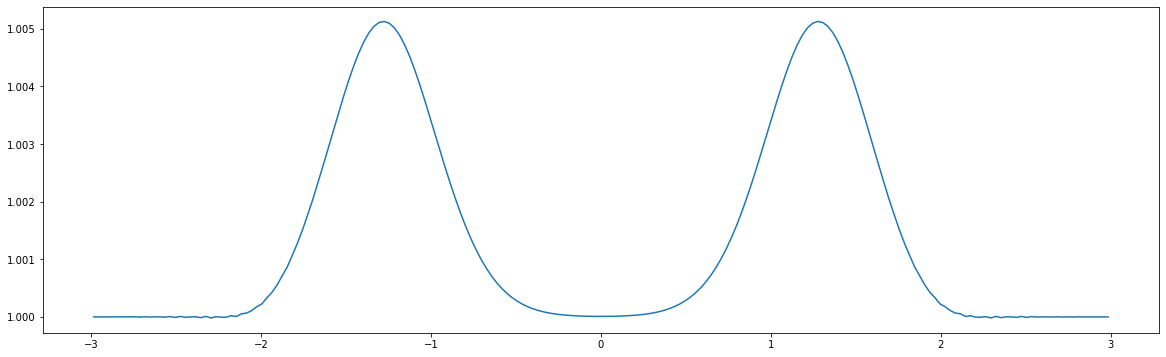

In [25]:
plt.figure(figsize = (20,6))
plt.plot(xt, h_old)